# Semantic Models & Metrics - NYC Mobility & Weather Analytics

This notebook explains the **semantic layer** built using dbt's MetricFlow framework.

## What is a Semantic Layer?

A **semantic layer** is an abstraction that sits between your data warehouse and business users. It:

- **Defines business logic once** - metrics calculated consistently everywhere
- **Provides a common language** - business terms mapped to technical tables
- **Simplifies data access** - users query "total_trips" instead of complex SQL
- **Ensures data governance** - centralized definitions prevent discrepancies

### Benefits

✅ **Consistency** - Everyone uses the same metric definitions  
✅ **Efficiency** - Write metrics once, use everywhere  
✅ **Discoverability** - Self-documenting with descriptions and labels  
✅ **Governance** - Single source of truth for business logic  

---

## Our Semantic Layer

This project uses **dbt MetricFlow** to define:
- **2 semantic models** (trips, hourly_mobility)
- **45+ metrics** across 4 categories
- **50+ dimensions** for slicing and dicing data

In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('default')
PROJECT_ROOT = Path.cwd().parent
DB_PATH = PROJECT_ROOT / 'data' / 'nyc_mobility.duckdb'
conn = duckdb.connect(str(DB_PATH), read_only=True)
print('Connected to DuckDB')

Connected to DuckDB


---

## Semantic Model #1: `trips`

**Description:** Trip-level granular data for detailed analysis

**Based on:** `fct_trips` fact table

**Grain:** One row per trip (12.5M records)

### Entities

| Entity | Type | Key | Description |
|--------|------|-----|-------------|
| `trip` | Primary | `trip_key` | Unique trip identifier |
| `date` | Foreign | `date_key` | Date dimension relationship |
| `time` | Foreign | `time_key` | Time dimension relationship |
| `pickup_location` | Foreign | `pickup_location_key` | Pickup location dimension |
| `dropoff_location` | Foreign | `dropoff_location_key` | Dropoff location dimension |

### Key Measures

- `trip_count` - Total number of trips
- `avg_trip_duration` - Average trip duration (minutes)
- `total_trip_distance` - Sum of all distances (miles)
- `avg_speed` - Average speed (mph)
- `total_revenue` - Total fare amount
- `avg_temperature` - Average temperature (°C)

### Key Dimensions

- `trip_type` - yellow_taxi, fhv, citibike
- `hour`, `day_part` - Time attributes
- `is_rush_hour`, `is_weekend` - Boolean flags
- `pickup_borough`, `dropoff_borough` - Location
- `temp_category`, `precipitation_type` - Weather
- `is_adverse_weather`, `is_pleasant_weather` - Weather conditions

---

## Metrics Catalog

Our semantic layer defines **45 metrics** organized into 4 categories:

### 1. Core Trip Metrics (13 metrics)

- `total_trips` - Total number of trips
- `avg_trip_duration_minutes` - Average duration
- `avg_trip_distance_miles` - Average distance
- `avg_trip_speed_mph` - Average speed
- `total_revenue` - Total fare amount
- `avg_fare` - Average fare per trip
- `revenue_per_mile` - Revenue efficiency (derived)

### 2. Mode Share Metrics (13 metrics)

- `yellow_taxi_trips`, `fhv_trips`, `citibike_trips`
- `yellow_taxi_mode_share_pct` - Percentage (derived)
- `rush_hour_yellow_taxi_trips` - Filtered metric

### 3. Time Pattern Metrics (16 metrics)

- `rush_hour_trips` - 7-9am, 5-7pm
- `weekend_trips`, `weekday_trips`
- `morning_trips`, `afternoon_trips`, `evening_trips`, `night_trips`
- `rush_hour_trip_rate` - Percentage (derived)

### 4. Weather Impact Metrics (13 metrics)

- `trips_in_adverse_weather`
- `trips_in_rain`, `trips_in_snow`
- `trips_in_cold_weather`, `trips_in_hot_weather`
- `adverse_weather_trip_rate` - Percentage (derived)

## Example 1: Core Trip Metrics

In [2]:
# Equivalent to: total_trips, avg_trip_duration_minutes, avg_trip_distance_miles
core_metrics = conn.execute("""
    SELECT 
        trip_type,
        COUNT(*) as total_trips,
        ROUND(AVG(trip_duration_minutes), 2) as avg_duration_minutes,
        ROUND(AVG(trip_distance), 2) as avg_distance_miles,
        ROUND(AVG(avg_speed_mph), 2) as avg_speed_mph
    FROM core_core.fct_trips
    GROUP BY trip_type
    ORDER BY total_trips DESC
""").fetchdf()

display(core_metrics)

,trip_type,total_trips,avg_duration_minutes,avg_distance_miles,avg_speed_mph
0,yellow_taxi,12659674,18.56,6.73,22.98
1,fhv,4586963,34.25,NaN,NaN
2,citibike,1417052,12.34,NaN,NaN


## Example 2: Mode Share Metrics

,trip_type,trips,mode_share_pct
0,yellow_taxi,12659674,67.83
1,fhv,4586963,24.58
2,citibike,1417052,7.59


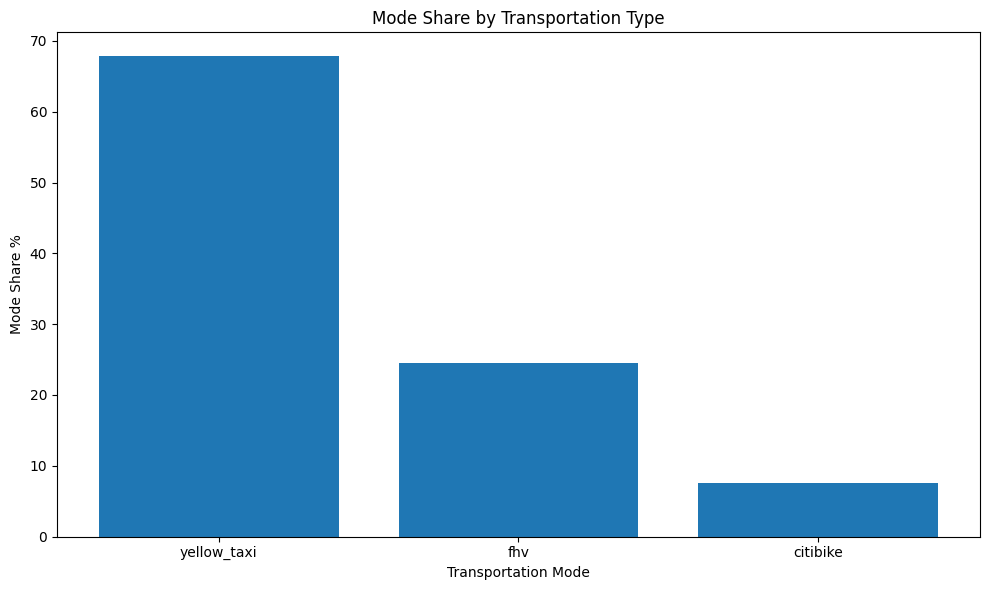

In [3]:
# Equivalent to: yellow_taxi_mode_share_pct, fhv_mode_share_pct, citibike_mode_share_pct
mode_share = conn.execute("""
    WITH total AS (
        SELECT COUNT(*) as total_trips FROM core_core.fct_trips
    )
    SELECT 
        trip_type,
        COUNT(*) as trips,
        ROUND(COUNT(*) * 100.0 / (SELECT total_trips FROM total), 2) as mode_share_pct
    FROM core_core.fct_trips
    GROUP BY trip_type
    ORDER BY mode_share_pct DESC
""").fetchdf()

display(mode_share)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(mode_share['trip_type'], mode_share['mode_share_pct'])
ax.set_xlabel('Transportation Mode')
ax.set_ylabel('Mode Share %')
ax.set_title('Mode Share by Transportation Type')
plt.tight_layout()
plt.show()

## Example 3: Time Pattern Metrics

In [4]:
# Equivalent to: rush_hour_trips, weekend_trips, weekday_trips
time_patterns = conn.execute("""
    SELECT 
        CASE WHEN d.is_weekend THEN 'Weekend' ELSE 'Weekday' END as period,
        CASE WHEN t.is_rush_hour THEN 'Rush Hour' ELSE 'Non-Rush Hour' END as time_type,
        COUNT(*) as trips
    FROM core_core.fct_trips ft
    JOIN core_core.dim_date d ON ft.date_key = d.date_key
    JOIN core_core.dim_time t ON ft.time_key = t.time_key
    GROUP BY d.is_weekend, t.is_rush_hour
    ORDER BY period, time_type
""").fetchdf()

display(time_patterns)

,period,time_type,trips
0,Weekday,Non-Rush Hour,10850125
1,Weekday,Rush Hour,3085158
2,Weekend,Non-Rush Hour,3469942
3,Weekend,Rush Hour,1258464


## Example 4: Weather Impact Metrics

In [5]:
# Equivalent to: trips_in_rain, trips_in_snow
weather_impact = conn.execute("""
    SELECT 
        precipitation_type,
        trip_type,
        COUNT(*) as trips,
        ROUND(AVG(trip_duration_minutes), 2) as avg_duration
    FROM core_core.fct_trips
    WHERE precipitation_type != 'none'
    GROUP BY precipitation_type, trip_type
    ORDER BY trips DESC
    LIMIT 10
""").fetchdf()

display(weather_impact)

,precipitation_type,trip_type,trips,avg_duration
0,rain,yellow_taxi,837821,18.72
1,rain,fhv,281042,25.54
2,rain,citibike,86468,11.50
3,snow,yellow_taxi,26698,21.33
4,mixed,yellow_taxi,9906,21.57
5,mixed,citibike,1457,8.12


## Example 5: Day Part Distribution

,day_part,trips,pct_of_total
0,morning,6758994,36.21
1,night,6123437,32.81
2,afternoon,4916338,26.34
3,evening,864920,4.63


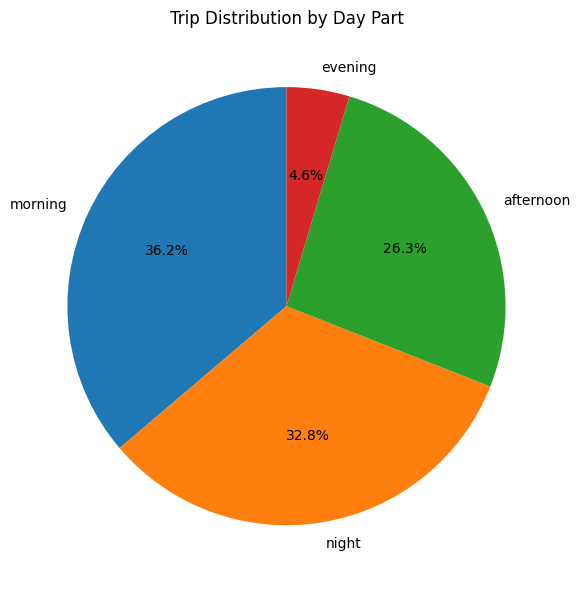

In [6]:
# Equivalent to: morning_trips, afternoon_trips, evening_trips, night_trips
day_parts = conn.execute("""
    SELECT 
        t.day_part,
        COUNT(*) as trips,
        ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (), 2) as pct_of_total
    FROM core_core.fct_trips ft
    JOIN core_core.dim_time t ON ft.time_key = t.time_key
    GROUP BY t.day_part
    ORDER BY trips DESC
""").fetchdf()

display(day_parts)

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(day_parts['trips'], labels=day_parts['day_part'], autopct='%1.1f%%', startangle=90)
ax.set_title('Trip Distribution by Day Part')
plt.tight_layout()
plt.show()

In [7]:
conn.close()
print('Connection closed')

Connection closed


---

## Key Takeaways

### Semantic Layer Benefits

1. **Centralized Business Logic** - Metrics defined once in YAML, used everywhere
2. **Self-Documenting** - Every metric has a description and label
3. **Type Safety** - Simple vs Derived metrics ensure correct calculations
4. **Reusability** - Derived metrics compose from simple metrics
5. **Governance** - Single source of truth prevents metric discrepancies

### Our Implementation

- **2 semantic models** for different analysis patterns
- **45 metrics** covering trips, mode share, time patterns, weather
- **50+ dimensions** for slicing data by time, location, weather
- **13 derived metrics** that compose from base metrics

### Resources

- **Semantic model files:** `dbt/models/marts/core/semantic_models/`
- **Metric definitions:** `dbt/models/marts/core/metrics/`
- **Data dictionary:** `docs/DATA_DICTIONARY.md`